In [1]:
from Hierarchy.PipelineFunctions.MainWorkers import times_when_method_better, MakeDendogram, generator, RunExperiment, ReadLogs
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import pickle

/var/folders/7g/1dqbz5hx5994z2r91kw1_k2m0000gn/T/ipykernel_24965/2474083448.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
def generation(size, dim):  
    distribution = sts.uniform(-1000, 1000)
    x = distribution.rvs(size).astype(int)
    
    if dim == 1:
        y = np.zeros(len(x))
    elif dim == 2:
        y = distribution.rvs(size).astype(int)

    points = list(zip(x, y))
    points = np.unique(points, axis=0)
    
    return np.array(points)

## Генерация или импорт выборок

In [10]:
# sample_size = 6
# iter_number = 100
# dim = 2
# file_name = generator(generation, 1000, sample_size, iter_number, dim)

In [11]:
direction_name = '1dim-100-100 2023-04-28 10:55:02'

file_name = './LOGS/' + direction_name + '/Samples'
main_info_about_sample = direction_name.split()[0].split("-")

dim = int(main_info_about_sample[0][0])
sample_size = int(main_info_about_sample[1])
iter_number_def = main_info_about_sample[2]

if 'k' in iter_number_def:
    iter_number = int(float(iter_number_def[:-1])) * 1000
else:
    iter_number = int(float(iter_number_def))

In [12]:
file_samples = open(file_name, 'rb')
Samples = pickle.load(file_samples)

## Запуск эксперимета

In [13]:
# for dist_metric in ('euclidean', 'cityblock', 'chebyshev'):
#     RunExperiment(dist_metric, file_name[:-8], Samples)

## Проверка на монотонность

In [14]:
# ПРОВЕРКА НА МОНОТОННОСТЬ
for file_ultra in (f"{file_name[:-8]}/{name}" for name in ('euclidean', 'cityblock', 'chebyshev')):
    TimeLogsList, Ultradists, MaxList, SumList, NameOfMethodList = ReadLogs(file_ultra)
    flag = 0
    for num, ultra in enumerate(Ultradists):
        if sorted(ultra) != ultra:
            display(HTML(f'<h4> The methods in {file_ultra}</h4>'))
            print(f"Пример номер {NameOfMethodList[num]}: {num}")
            print(ultra)
            print()
            flag = 1
    if flag != 1:
        display(HTML(f'<h4> The methods in {file_ultra} is monotonous</h4>'))

## Сравнение результатов

In [ ]:
ResultsForMaxList = {}
ResultsForSumList = {}
for dist_metric in ('euclidean', 'cityblock', 'chebyshev'):
    dist_metric_dir = f"./LOGS/{direction_name}/{dist_metric}"
    
    TimeLogsList, Ultradists, MaxList, SumList, NameOfMethodList = ReadLogs(dist_metric_dir)

    MaxMatrix = pd.DataFrame({'MetricsByMethodsForMax': MaxList, 'NameOfMethod': NameOfMethodList})
    grouper = MaxMatrix.groupby('NameOfMethod')
    ResultsForMax = pd.concat([pd.Series(v['MetricsByMethodsForMax'].tolist(), name=k) for k, v in grouper], axis=1)
    ResultsForMaxList[dist_metric] = ResultsForMax

    SumMatrix = pd.DataFrame({'MetricsByMethodsForSum': SumList, 'NameOfMethod': NameOfMethodList})
    grouper = SumMatrix.groupby('NameOfMethod')
    ResultsForSum = pd.concat([pd.Series(v['MetricsByMethodsForSum'].tolist(), name=k) for k, v in grouper], axis=1)
    ResultsForSumList[dist_metric] = ResultsForSum

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))

for k, (dist_metric, resmax) in enumerate(ResultsForMaxList.items()):
    if k == 0:
        sns.heatmap(data=times_when_method_better(resmax), ax=axes[k], annot=True, cbar=False)
        axes[k].set_title(dist_metric)
    else:
        sns.heatmap(data=times_when_method_better(resmax), ax=axes[k], annot=True, cbar=False, yticklabels=False)
        axes[k].set_title(dist_metric)

fig.suptitle(f'Максимальное отклоненние, ({dim} dim: {sample_size} точек - {iter_number} опытов)', fontsize=16)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(20,5))

for k, (dist_metric, ressum) in enumerate(ResultsForSumList.items()):
    if k == 0:
        sns.heatmap(data=times_when_method_better(ressum), ax=axes[k], annot=True, cbar=False)
        axes[k].set_title(dist_metric)
    else:
        sns.heatmap(data=times_when_method_better(ressum), ax=axes[k], annot=True, cbar=False, yticklabels=False)
        axes[k].set_title(dist_metric)

fig.suptitle(f'Сумма отклоненний, ({dim} dim: {sample_size} точек - {iter_number} опытов)', fontsize=16)
plt.show()

In [ ]:
print("Метрика Максимального отклонения: случаи когда min_max_linked больше другого метода\n")
for dist_metric, resmax in ResultsForMaxList.items():
    print(dist_metric.upper())
    flag = 0
    for col in resmax.columns:
        exp = list(resmax.query(f'min_max_linked > {col}').index)
        if len(exp) != 0:
            print(f"{col}: {exp}\n")
            flag += 1

    if flag == 0:
        print("Случаев не обнаружено\n")

In [ ]:
print("Метрика Суммы отклонений: случаи когда median_linked больше другого метода\n")
for dist_metric, ressum in ResultsForSumList.items():
    print(dist_metric.upper())
    flag = 0
    for col in ressum.columns:
        exp = list(ressum.query(f'median_linked > {col}').index)
        if len(exp) != 0:
            print(f"{col}: {exp}\n")
            flag += 1

    if flag == 0:
        print("Случаев не обнаружено\n")

## Анализ

In [ ]:
test_data = np.array([
    [0, 0],
    [10, 0],
    [17, 0],
    [18, 0],
    [24, 0]
])

In [ ]:
# test_data = Samples[160]
pd.DataFrame(test_data, columns=['x', 'y'])

In [ ]:
from Hierarchy.MedianMethod import MedianHierarchy
from Hierarchy.MinMaxMethod import MinMaxHierarchy
from Hierarchy.StandartMethods import hierarchy
from Hierarchy.ToCulcMethods.Linkages import single_linked, complete_linked, group_average_linked, weighted_average_linked, ward_linked
from Hierarchy.ToCulcMethods.UltrametricMatrix import ultramatrix

In [ ]:
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.scatter(test_data[:, 0], test_data[:, 1])

for i in range(len(test_data)):
    plt.text(test_data[i][0], test_data[i][1] + 0.005, str(i))

In [ ]:
# ('euclidean', 'cityblock', 'chebyshev'):
output1 = MinMaxHierarchy(test_data, logs_turn_on=True, metric='euclidean')
# MedianHierarchy(test_data, logs_turn_on=True, metric='euclidean')
output1

In [ ]:
diff = np.abs(output1[1] - ultramatrix(output1[0], output1[2]))
max_abs = np.max(diff)
max_abs

In [ ]:
# MakeDendogram(test_data, output1[2])

In [ ]:
output2 = hierarchy(test_data, metric='euclidean', method=group_average_linked, logs_turn_on=True)
output2

In [ ]:
# MakeDendogram(test_data, output2[2])

In [ ]:
diff = np.abs(output2[1] - ultramatrix(output2[0], output2[2]))
max_abs = np.max(diff)
max_abs

In [ ]:
# from scipy.cluster import hierarchy as scipy_hierarchy


# temp = scipy_hierarchy.linkage(test_data, 'ward')
# plt.figure()
# dn = scipy_hierarchy.dendrogram(temp)

# for i, d in zip(dn['icoord'], dn['dcoord']):
#     x = 0.5 * sum(i[1:3])
#     y = d[1]
#     plt.plot(x, y, 'ro')
#     plt.annotate(y, (x, y), xytext=(0, -8),
#                     textcoords='offset points',
#                     va='top', ha='center')

## Поиск корреляции

In [17]:
# 'euclidean', 'cityblock', 'chebyshev'

dist_metric_dir = f"./LOGS/1dim-100-100 2023-04-28 10:55:02/euclidean"
TimeLogsList, Ultradists, MaxList, SumList, NameOfMethodList = ReadLogs(dist_metric_dir)

In [59]:
# pd.DataFrame(, Ultradists)
# len(NameOfMethodList)
# len(Ultradists)
med_ind = [method_index for method_index, method in enumerate(NameOfMethodList) if method == 'median_linked']

In [61]:
med_ultras = [Ultradists[ult] for ult in med_ind]

In [66]:
emed_ult = med_ultras[0]

In [80]:
x1 = emed_ult[:-2]
x2 = emed_ult[1:-1]
y = emed_ult[2:]
emed_data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [124]:
X = emed_data[['x1', 'x2']]
y = emed_data[['y']]

In [126]:
reg = LinearRegression().fit(X[['x1']], y)

In [128]:
reg.score(X[['x1']], y)

0.9293827120818432

In [129]:
reg.coef_

array([[2.01878026]])

In [130]:
reg.intercept_

array([-57.20636001])

In [95]:
mean_squared_error(y, reg.predict(X))

3902.9053905365104

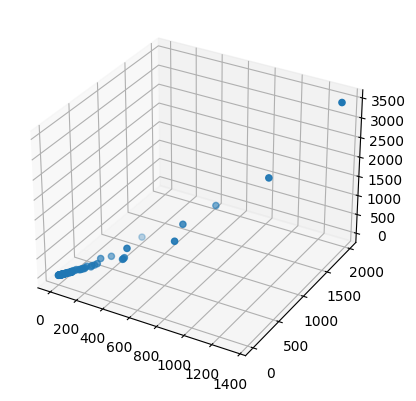

In [100]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(X['x1'], X['x2'], y)

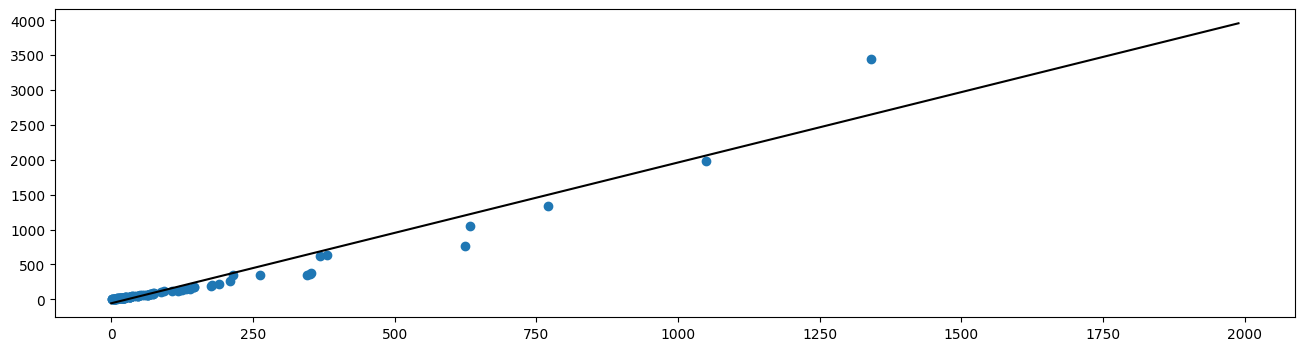

In [131]:
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.scatter(X['x1'], y)
plt.plot(np.linspace(0,1989, 1000), 2.01878026 * np.linspace(0,1989, 1000) -57.20636001, color='k') 

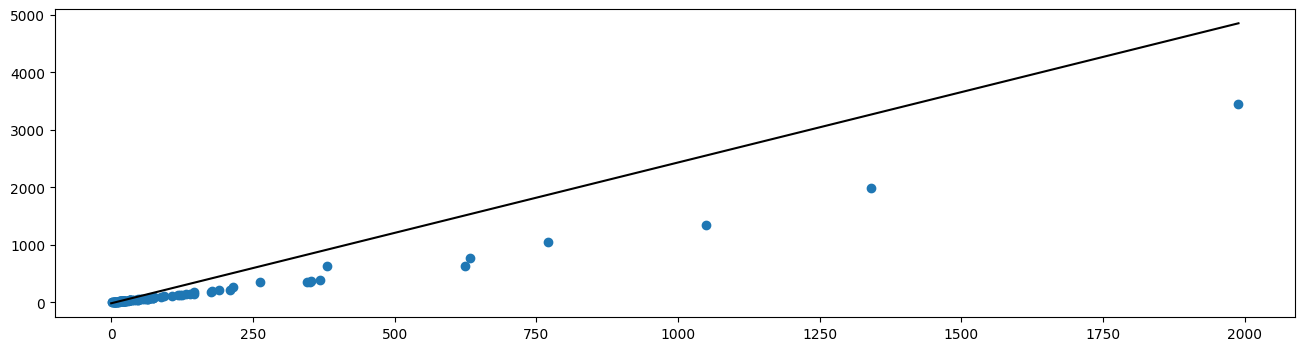

In [119]:
fig = plt.figure()
fig.set_size_inches(16, 4)
plt.scatter(X['x2'], y)
plt.plot(np.linspace(0,1989, 1000), 2.44583262 * np.linspace(0,1989, 1000) - 16.18561686, color='k') 